In [1]:
# imports
import mesh_manager as mema 
import solvers.hho as hho
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from matplotlib.lines import Line2D
from matplotlib.patches import Polygon as Polygon
import os
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import spsolve
import random
import pickle
import pandas as pd
import copy
plt.rcParams['text.usetex'] = True

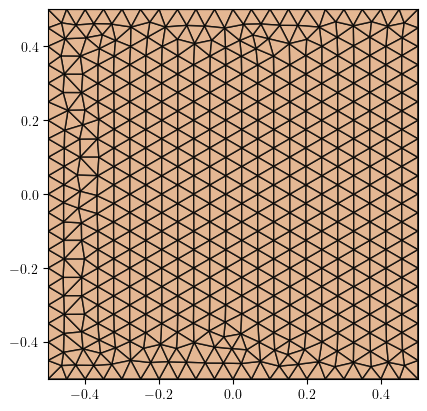

In [2]:
# load a triangular mesh and visualize
mesh0 = mema.load_square_mesh("meshes/square_L1_N20.msh")

fig, ax = plt.subplots()
ax.set_aspect('equal')
ax.set_xlim([-.5, .5])
ax.set_ylim([-.5, .5])
mema.visualize_mesh(mesh0, ax)




In [3]:
def refine_mesh(mesh0, debug= False):
    """
    Refines a triangular mesh; triangular in shape,
    but not necessarily as for no of points
    (we want to be able to realize several levels of refinement)
    XXX: currently with a dummy cryterion

    Args:
        mesh(mema.mesh2D): mesh to refine
        debug (bool): print messages 
    Returns:
        mema.mesh2D
    """

    new_coords       = copy.deepcopy(mesh0.coords)
    new_elem2node    = copy.deepcopy(mesh0.elem2node)
    deleted_elements = [] # list of refined elements to delete
    added_elements   = [] # list of created child elements

    if debug: counter = 0 # 

    # new_eleme2node is a dynamical list of elements, whose
    # size is fixed, but whose elements can change size
    # during the refinement procedure;
    # during the loop there is a 1:1 correspondence between
    # elements of mesh0 end elements of new_eleme2node

    for iel in range(mesh0.no_elems):
        
        nodes = new_elem2node[iel] # the dynamical version, potentially already modified with new nodes
        elem_node_coords = [new_coords[node] for node in nodes]
        
        if (cryterion_checked(elem_node_coords)):

            #if debug: 
                # if counter > 2: break

            # get the nodes 
            
            if debug: print ("************************************")
            if debug: print ("Element to refine: ", iel)
            if debug: print ("Nodes of element to refine: ", nodes)
            if debug: print ("Coords of nodes of element to refine: ", elem_node_coords)
            # get the vertices (3 nodes thata are vertices of triangle)
            # it is ok to suppose that the vertices are three even when applying recursively,
            v0, v1, v2 = get_triangle_vertices(new_elem2node, new_coords, iel) # local indexes
            # get the three segments of the boundary (with extrema included)
            segments = [
                nodes[v0:v1+1],
                nodes[v1:v2+1],
                nodes[v2:]+nodes[0:v0+1]
            ]
            if debug: print (v0, v1, v2)
            if debug: print ("Three segments: ", segments)
            
            # inspect each segment
            midpoints = []
            subedges = [] # the two lists of points making up the subedges (with extrema)
            for segment in segments:
                v0             = segment[0]
                v1             = segment[-1]
                v0_coord       = new_coords[segment[0]]
                v1_coord       = new_coords[segment[-1]]
                midpoint_coord = 0.5*(v0_coord+v1_coord)
                # if segment composed of only two points, it is a proper edge, then it has to be broken
                if (len(segment)==2):
                    if debug: print ("Segment is still not cut")
                    # add midpoint to the global list of points (coords) and add it to set of midpoints
                    midpoint = len(new_coords) # index of new point
                    new_coords.append(midpoint_coord)
                    # also, get the two subedges
                    subedge0 = [v0, midpoint]
                    subedge1 = [midpoint, v1]
                    # look for element sharing the extrema of the edge (only one must be found)
                    if debug: print ("Edge to be split: ", [v0, v1])
                    neigh, split_ie = get_neighbor(new_elem2node, iel, v0, v1)
                    # add the point to the element
                    neigh_point_list   = new_elem2node[neigh]
                    neigh_size = len(neigh_point_list)
                    if debug: print ("Found a neighbor: ", neigh_point_list)
                    if debug: print ("Insert midpoint after node: ", split_ie)
                    if debug: print ("Midpoint: ", midpoint)
                    #new_elem2node[neigh] = neigh_point_list[0:(split_ie+1)%neigh_size]+[midpoint]+neigh_point_list[(split_ie+1)%neigh_size:]
                    new_elem2node[neigh] = neigh_point_list[0:split_ie+1]+[midpoint]+neigh_point_list[split_ie+1:]
                    if debug: print ("Modified neighbor:", new_elem2node[neigh])
                # else, get the two subedges
                else:
                    # get the midpoint; the one with the right coordinate
                    for idx, ino in enumerate(segment):
                        if mema.R2_norm(new_coords[ino]-midpoint_coord)<1e-12:
                            midpoint_idx = idx # local index
                            midpoint = ino
                    if debug: print ("midpoint: ", midpoint)
                    subedge0 = segment[0:midpoint_idx + 1] # midpoint included
                    subedge1 = segment[midpoint_idx:]
                    if debug: print ("Edge already split divided into: ", subedge0, subedge1)
                # collect the midpoints and subedges
                midpoints.append(midpoint)
                subedges.append([subedge0, subedge1])               
 
            # compose the 4 children elements by connecting the subedges and the midpoints
            # XXX HERE WE MAKE A PRECISE CHOICE FOR ORDERING
            # XXX attention to excluding last point of each list of points

            child0 = subedges[0][0] + subedges[2][1][0:-1]
            child1 = subedges[1][0] + subedges[0][1][0:-1]
            child2 = subedges[2][0] + subedges[1][1][0:-1]
            child3 = midpoints

            if debug: print ("Children ", child0, child1, child2, child3)

            # add children elements to the list of new elements 
            added_elements += [child0, child1, child2, child3]
            # add the refined element to the list of elements to cancel
            deleted_elements.append(iel)

            if debug: counter +=1 # debug: stop after first refined element 

    # get the list of elements of the new refined mesh
    if debug: print("*************************")
    if debug: print("*************************")
    if debug: print ("Deleted Elements: ", deleted_elements)
    purged_new_elem2node = [elem for iel, elem in enumerate(new_elem2node) if iel not in deleted_elements]
    new_elem2node = purged_new_elem2node + added_elements            

    return mema.mesh2D(new_elem2node, new_coords, bnd_dof_type='edge', d=mesh0.d)

def cryterion_checked (elem_coords):
    """
    Check if cryterion to refine is respected
    XXX dummy cryterion 

    Args:
        elem_coords: element node coordinates
    Returns:
        bool
    """
    node_dist_from_circle = [ (mema.R2_norm(p) - 0.25) for p in elem_coords] # radius of the vertices
    first_value = node_dist_from_circle[0]
    for idx in range(1,len(node_dist_from_circle)):
        next_value = node_dist_from_circle[idx]
        if (first_value*next_value<0):
            return True
    return False

def get_triangle_vertices(elem2node, coords, iel):
    """
    Given a polygon with a triangular shape (such as those that you can get after nonconformal refinement (hanging nodes))
    Extracts the vertices of the triangle (local index)
    Beware: it only works with actual triangles, don't apply after breaking along the mesh
    """
    nodes    = elem2node[iel]
    size     = len(nodes)
    vertices = []

    for ino, node in enumerate(nodes): 
        # coords of node get adjacent points
        p       = coords[node]
        p_left  = coords[nodes[(ino-1)%size]]
        p_right = coords[nodes[(ino+1)%size]]
        # get the two vectors stemming from p
        v_left  = p_left  - p
        v_right = p_right - p
        # if they dont'make an acute angle they're not vertices
        if (v_left[0]*v_right[0] + v_left[1]*v_right[1])>0: # dot product is negative for nodes between collinear adjacent points
             vertices.append(ino)

    return vertices

def get_neighbor(elem2node, iel, v0, v1):
    """
    Look for the element sharing with iel the vertices v0 and v1

    Args:
        elem2node(list): current list of element, already modified with new points
        v0 (int): vertex 0 (index)
        v1 (int): vertex 1 (index)
    Returns:
        int: index of found neighbor
        int: local index of edge to split
    """

    for iel_cand, candidate in enumerate(elem2node):
        if (iel_cand!=iel): # XXX: since indexes are swapped it should not be necessary to check this
            for index, node in enumerate(candidate):
                # beware: v0 and v1 are swapped in neighbor element since nodes are listed counterclock-wise
                if (node==v1 and candidate[(index+1)%len(candidate)]==v0):
                    return iel_cand, index
        
    # If not found
    raise ValueError(f"No neighboring element found")

In [4]:
# refine the mesh 4 times
meshes = [mesh0]
for k in range(4):
   ref_mesh = mema.refine_mesh(meshes[k], debug=False)
   meshes.append(ref_mesh)

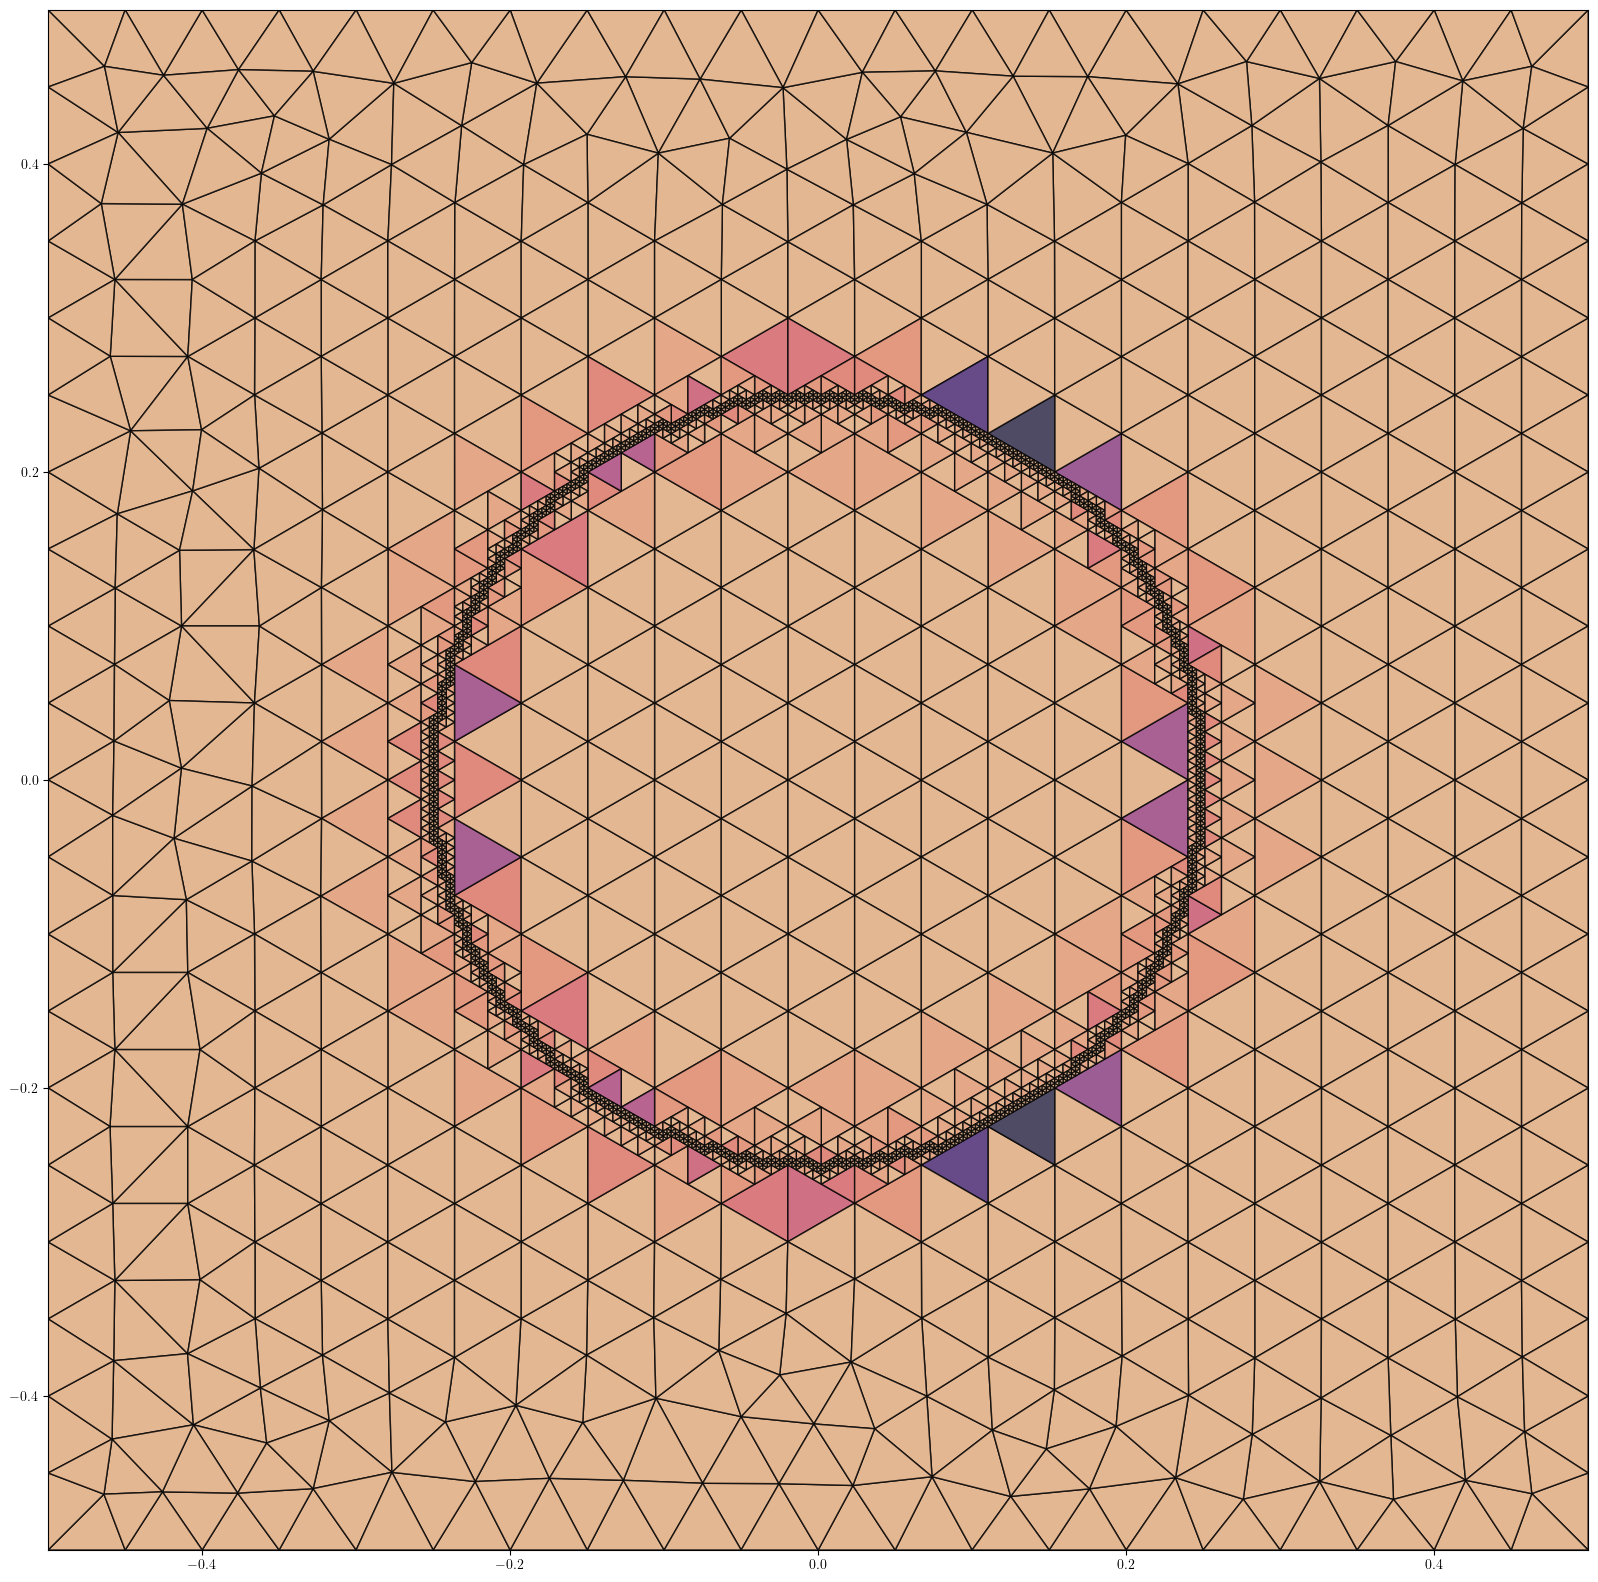

In [5]:
fig, ax = plt.subplots(figsize=(20,20))
ax.set_aspect('equal')
ax.set_xlim([-.5, .5])
ax.set_ylim([-.5, .5])
mema.visualize_mesh(meshes[-1], ax, display_no_nodes=False, display_elem_id = False)

In [ ]:
def get_clip(subjectPolygon, clipPolygon):
   """
   Determine clip between two polygons using Sutherland-Hodgman algorithm.
   (adapted from: https://rosettacode.org/wiki/Sutherland-Hodgman_polygon_clipping#Python)
   For reference: https://en.wikipedia.org/wiki/Sutherland%E2%80%93Hodgman_algorithm
      
   """
   def inside(p):
      # Use >= instead of > to include boundary points
      return(cp2[0]-cp1[0])*(p[1]-cp1[1]) >= (cp2[1]-cp1[1])*(p[0]-cp1[0])
   def computeIntersection():
      dc = [ cp1[0] - cp2[0], cp1[1] - cp2[1] ]
      dp = [ s[0] - e[0], s[1] - e[1] ]
      n1 = cp1[0] * cp2[1] - cp1[1] * cp2[0]
      n2 = s[0] * e[1] - s[1] * e[0] 
      denom = dc[0] * dp[1] - dc[1] * dp[0]
      
      # Handle parallel lines (avoid division by zero)
      if abs(denom) < 1e-10:
         return (s + e) * 0.5  # Return midpoint as fallback
      
      n3 = 1.0 / denom
      return np.array([(n1*dp[0] - n2*dc[0]) * n3, (n1*dp[1] - n2*dc[1]) * n3])

   outputList = list(subjectPolygon)
   cp1 = np.asarray(clipPolygon[-1], dtype=float)
   
   for clipVertex in clipPolygon:
      cp2 = np.asarray(clipVertex, dtype=float)
      if not outputList:  # Early exit if polygon is clipped away
         break
      inputList = outputList
      outputList = []
      s = np.asarray(inputList[-1], dtype=float)

      for subjectVertex in inputList:
         e = np.asarray(subjectVertex, dtype=float)
         if inside(e):
            if not inside(s):
               outputList.append(computeIntersection())
            outputList.append(e)
         elif inside(s):
            outputList.append(computeIntersection())
         s = e
      cp1 = cp2
   
   return outputList


#polygon1 = [np.array([0., 0.]), np.array([0.,1.]), np.array([1., 0.])]
#polygon2 = [np.array([-1., -1.]), np.array([1.5,-1.]), np.array([1., 1.5])]
#
#polygon2 = [p*1e-6 for p in polygon1]
#
#print(get_clip(polygon1,polygon1))
#print([type (p) for p in  get_clip(polygon1,polygon2)])
#
#get_clip (intface.coords, polygon2)

def barycenter(polygon):
   """
   Compute baricenter of a polygon
   
   Args:
   polygon (list(np.array))
   """
   
   return sum(polygon)/len(polygon)



# Test where cryterion is intersection with interface
intface = mema.initialize_disk_interface(N=400, rho=0.25, k_b = 1, k_str=1)
#deform intface
dt=1
intface.coords = [np.array([p[0]+p[1]*dt, p[1]]) for p in intface.coords]

def intface_cryterion (iel, elem_coords, intface):
    """
    Check if element is intersected by interface

    Args:
        iel (int): element index
        elem_coords(list): element node coordinates
        intface (mema.disk_intface): interface
    Returns:
        bool
    """
    # get pseudo triangle
    vertices_idx = mema.get_triangle_vertices(elem_coords)
    triangle_coords = [elem_coords[k] for k in vertices_idx]

    hT = mema.R2_norm(triangle_coords[0]-triangle_coords[1])
    tol = 1e-6
    clip = get_clip(intface.coords, triangle_coords)
    # intersected if clip is not empty and does not coincide with clipping element (because the latter is entirely contained) 
    if (clip==[]):
        return False
    if (mema.R2_norm(barycenter(triangle_coords) - barycenter(clip))/hT < tol):
        #print (mema.R2_norm(barycenter(elem_coords) - barycenter(clip))/hT)
        return False
    
    return True

def harmonize_cryterion (iel, elem_coords):
    """
    Check if element has neighbors that are too small

    Args:
        iel (int): element index
        elem_coords(list): element node coordinates
    Returns:
        bool
    """
    short_side = 1e16
    long_side  = 1e-16
    tol        = 1/4
    for ino in range(len(elem_coords)):
        h          = mema.R2_norm(elem_coords[(ino+1)%len(elem_coords)]-elem_coords[ino])
        short_side = min(short_side, h)
        long_side  = max(long_side, h)
    
    if (short_side/long_side < tol):
        return True
    
    return False

meshes = [mesh0]
for k in range(5):
   ref_mesh = mema.refine_mesh(meshes[k], cryterion=intface_cryterion, additional_arguments=[intface], debug= False)
   meshes.append(ref_mesh)

print ("First step done")

# harmonize: avoid elements with too many edges, that is with neigbours that are too small
for k in range(3):
   ref_mesh = mema.refine_mesh(meshes[4+k], cryterion=harmonize_cryterion, additional_arguments=[], debug= False)
   meshes.append(ref_mesh)
#break the mesh
broken_mesh = mema.break_mesh(meshes[-1], intface, execute_fill_side_mask=False)

fig, ax = plt.subplots(figsize=(20,20))
ax.set_aspect('equal')
ax.set_xlim([-.5, .5])
ax.set_ylim([-.5, .5])
#mema.visualize_mesh(meshes[-1], ax, display_no_nodes=False, display_elem_id = False)
mema.visualize_mesh(broken_mesh, ax, display_no_nodes=False, display_elem_id = False)
#mema.visualize_intface(fig, ax, intface)

In [7]:
# test refinement with cryterion based on velocity gradient
U_max = 1e6
d = 0.5
velocity = [np.array([-U_max/d**2*(y-d)*(y+d), 0.]) for x,y in mesh0.element_barycenter]
velocity_norm = [mema.R2_norm(v) for v in velocity]
v_grad_norm = [ abs(U_max/d**2*(-2*y)) for x,y in mesh0.element_barycenter]

# a fake boundary layer
M=10
velocity_norm = [np.exp(M*y)-1 for x,y in mesh0.element_barycenter]
v_grad_norm = [ M*np.exp(M*y) for x,y in mesh0.element_barycenter]

# gradient cryterion
def v_grad_cryterion (iel, elem_coords, v_norm, v_grad_norm, N):
    """
    If estimated max dV across element is too large with respect to a refinement cryterion

    Args:
        elem_coords(list): element node coordinates
        v_norm (float): velocity norm field
        v_grad_norm (float): velocity gradient norm field
        N (int): refinement  
    Returns:
        bool
    """
    hT = mema.R2_norm(elem_coords[0]-elem_coords[1])
    U_range = max(v_norm) - min(v_norm)
    dV = U_range/N

    if (hT> dV/v_grad_norm[iel]):
        return True
    
    return False

meshes = [mesh0]
for k in range(5):
   ref_mesh = mema.refine_mesh(meshes[k], cryterion=v_grad_cryterion, additional_arguments=[velocity_norm, v_grad_norm, 40], debug= False)
   meshes.append(ref_mesh)

  # velocity = [np.array([-U_max/d**2*(y-d)*(y+d), 0.]) for x,y in meshes[-1].element_barycenter]
  # velocity_norm = [mema.R2_norm(v) for v in velocity]
  # v_grad_norm = [ abs(U_max/d**2*(-2*y)) for x,y in meshes[-1].element_barycenter]

   velocity_norm = [np.exp(M*y)-1 for x,y in meshes[-1].element_barycenter]
   v_grad_norm = [ M*np.exp(M*y) for x,y in meshes[-1].element_barycenter]



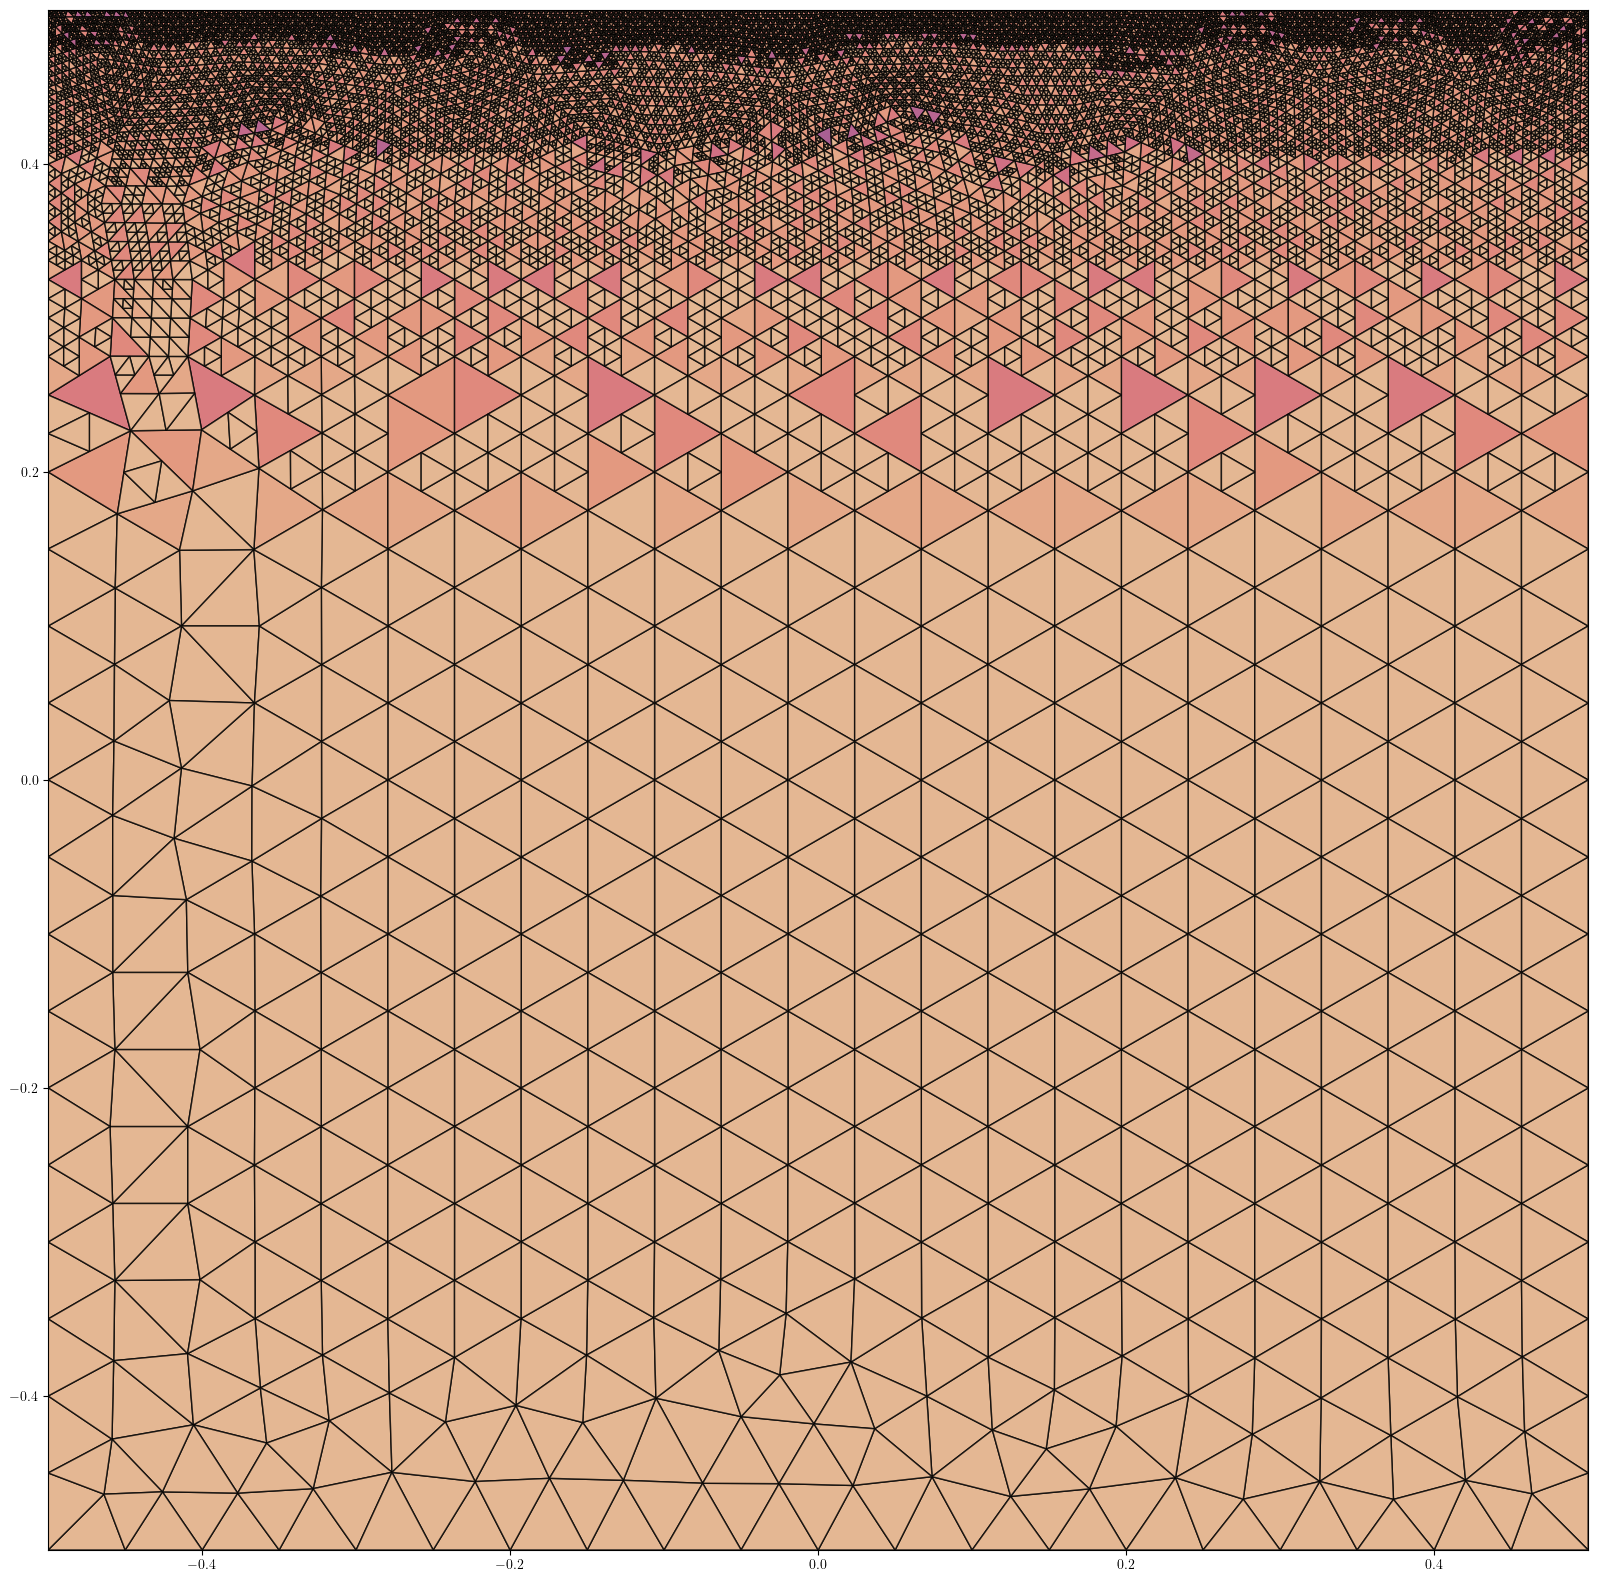

In [8]:
fig, ax = plt.subplots(figsize=(20,20))
ax.set_aspect('equal')
ax.set_xlim([-.5, .5])
ax.set_ylim([-.5, .5])
#cryt_mask = [int(intface_cryterion([mesh0.coords[k] for k in elem], intface)) for elem in mesh0.elem2node]
#mema.visualize_mesh(mesh0, ax, display_no_nodes=False, display_elem_id = True)
#mema.visualize_mesh_element_data(mesh0, cryt_mask, ax=ax)
#mema.visualize_mesh_element_data(mesh0, velocity_norm, ax=ax, binary=False, cmap='viridis')
#mema.visualize_mesh_element_data(mesh0, v_grad_norm, ax=ax, binary=False)
mema.visualize_mesh(meshes[-1], ax)
#mema.visualize_intface(fig, ax, intface)